# S2. Red convolucional para CIFAR-10

[**CIFAR-10:**](https://www.cs.toronto.edu/~kriz/cifar.html) $\;$ corpus de $60\,000$ imágenes $32\times 32$ a color RGB de 10 clases, con $6\,000$ imágenes por clase

* Publicado en 2009, CIFAR-10 es uno de los [corpus más populares en ML de los últimos años](https://paperswithcode.com/datasets?q=&v=lst&o=cited)

**Ejemplo:** $\;$ lectura de CIFAR-10

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
cifar_10_X, cifar_10_y = fetch_openml('CIFAR_10', return_X_y=True, as_frame=False, parser='auto')

Generamos la partición de $50\,000$ imágenes de training y $10\,000$ imágenes de test

In [3]:
x_train = cifar_10_X[:50000]; y_train = cifar_10_y[:50000].astype('uint8')
x_test = cifar_10_X[50000:]; y_test = cifar_10_y[50000:].astype('uint8')
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 3072) (50000,) (10000, 3072) (10000,)


Podemos visualizar algunas de la imágenes de CIFAR-10 para valorar la complejidad de la tarea

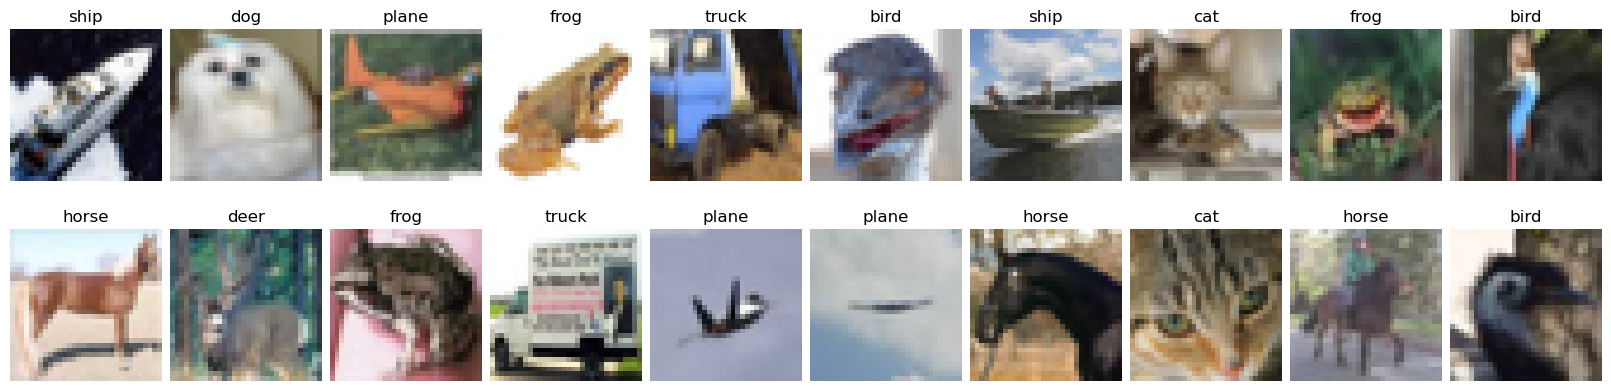

In [6]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, x_train, y_train):
    ax.set_axis_off(); image = x.reshape(3, 32, 32).transpose(1, 2, 0); ax.set_title(labels[y])
    ax.imshow(image, interpolation="none")

Como en la anterior práctica, una vez importado el conjunto de imágenes las normalizamos y definimos un conjunto de validación a partir del training

In [4]:
## Normalizar datos
from tensorflow import keras

print('training set', x_train.shape)
print('test set', x_test.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = x_train.reshape(40000, 3, 32, 32)
x_val = x_val.reshape(10000, 3, 32, 32)
x_test = x_test.reshape(10000, 3, 32, 32)

print('training set', x_train.shape)
print('val set', x_val.shape)
print('test set', x_test.shape)

2023-11-24 09:57:39.739332: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 09:57:39.903080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 09:57:39.903215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 09:57:39.928873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 09:57:39.989495: I tensorflow/core/platform/cpu_feature_guar

training set (50000, 3072)
test set (10000, 3072)
training set (40000, 3, 32, 32)
val set (10000, 3, 32, 32)
test set (10000, 3, 32, 32)


## Modelo base
Como punto de partida tomaremos la topología base de la anterior sesión y la adaptaremos para que pueda trabajar con imágenes en RGB. Como podrás comprobar es importante especificar que los canales RGB, y por tanto los filtros resultantes, son la primera dimensión. Asegúrate que ejecutas en GPU, ya que la ejecución de AveragePooling2D en CPU da un error.
 

In [28]:
from keras import Sequential
from keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

model = Sequential()

model.add(Input((3,32,32)))
model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(3,32,32),data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(2,2), strides=2, data_format='channels_first'))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(2,2), strides=2, data_format='channels_first'))
model.add(Flatten(data_format='channels_first'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

#model.summary()

opt=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

epochs=25
batch_size=128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr,checkpoint])  

## Cargar el mejor modelo y evaluarlo con el test set
model = keras.models.load_model('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]*100:.2f}')
print(f'Test accuracy: {score[1]*100:.2f}')

Epoch 1/25
310/313 [============================>.] - ETA: 0s - loss: 1.6525 - accuracy: 0.3973
Epoch 1: val_accuracy improved from -inf to 0.47980, saving model to best_model.h5
313/313 [==============================] - 3s 6ms/step - loss: 1.6501 - accuracy: 0.3980 - val_loss: 1.4263 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 2/25
307/313 [============================>.] - ETA: 0s - loss: 1.3574 - accuracy: 0.5113
Epoch 2: val_accuracy improved from 0.47980 to 0.54650, saving model to best_model.h5
313/313 [==============================] - 2s 6ms/step - loss: 1.3555 - accuracy: 0.5120 - val_loss: 1.2719 - val_accuracy: 0.5465 - lr: 0.0010
Epoch 3/25
310/313 [============================>.] - ETA: 0s - loss: 1.2164 - accuracy: 0.5656
Epoch 3: val_accuracy improved from 0.54650 to 0.56350, saving model to best_model.h5
313/313 [==============================] - 2s 6ms/step - loss: 1.2164 - accuracy: 0.5657 - val_loss: 1.2254 - val_accuracy: 0.5635 - lr: 0.0010
Epoch 4/25
305/313 [=====

## Ejercicio:

Como podrás comprobar la tasa de acierto conseguida en CIFAR-10 dista de la conseguida en MNIST que estaba próxima al 99%. Prueba a mejorar la tasa de acierto de este modelo base aplicando las técnicas presentadas en la práctica 1 (dropout, batchnorm y aumento de datos). Considera también la posibilidad de cambiar la topología base inspirándote en otras como AlexNet, pero adaptándola a la tarea de CIFAR-10.